If running in a new enviroment, such as Google Colab, run this first.

In [3]:
 !git clone https://github.com/zach401/acnportal.git
 !pip install acnportal/.

Cloning into 'acnportal'...
remote: Enumerating objects: 6790, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 6790 (delta 47), reused 100 (delta 45), pack-reused 6681
Receiving objects: 100% (6790/6790), 3.54 MiB | 4.68 MiB/s, done.
Resolving deltas: 100% (4651/4651), done.
Processing ./acnportal
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 13.9 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for acnportal: filename=acnportal-0.3.2-py3-none-any.whl size=118583 sha256=2ec2aa931313a969c151c641355b1eed4e30cbca3b34556a933cff2246cde879
  Stored in directory: /private/var/folders/l4/pcg7hmbx5l16p94wstmvj0mh0000gn/T/pip-ephem-wheel-cache-jd480u22/wheels/e0/7d/35/6b5e59db34a92c47fad86b1a7159419f7272c343d549fca13e
  Created wheel for pandas: filen

# ACN-Sim Tutorial: Lesson 1
## Running an Experiment
### by Zachary Lee
#### Last updated: 03/19/2019

In this first lesson we will learn how to setup and run a simulation using a built-in scheduling algorithm. After running the simulation we will learn how to use the analysis subpackage to analyze the results of the simulation.

In [4]:
import pytz
from datetime import datetime

import matplotlib.pyplot as plt

from acnportal import acnsim
from acnportal import algorithms

### Experiment Parameters 

Next we need to define some parameters of the experiment. We define these at the begining of the file so they can be used consistently when setting up the simulation.

In [5]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2018, 9, 5))
end = timezone.localize(datetime(2018, 9, 6))

# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 220  # volts

# Default maximum charging rate for each EV battery.
default_battery_power = 32 * voltage / 1000 # kW

# Identifier of the site where data will be gathered.
site = 'caltech'

### Network 

An important part of any simulation is the ChargingNetwork on which it runs. The ChargingNetwork is a description of the physical system and contains both the set of EVSEs which make up the network as well as a constraint_matrix which represents the electrical infrastructure of the network. You can manually configure this network using the register_evse() and add_constraint() methods in ChargingNetwork or you can use a predefined network available in the sites module. In this case we use the predefined CaltechACN network.

In [6]:
# For this experiment we use the predefined CaltechACN network.
cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)

### Events

Events are what drive action in the simulator. Events are stored in an EventQueue. This queue can be built manually by creating an Event object and using the add_event() or add_events() methods, or can be generated automatically.

In this case we will use acndata_events.generate_events() which is part of the events subpackage. acnevents provides utilities for generating events from the Caltech Charging Dataset. These events are based on real behavior of users charging actual EVs, so it is extremely valuable for running realistic simulations. In order to access the API we need a token. For now we can use the demo token, but it is highly recomended that you register for your own free token at ev.caltech.edu.

In [7]:
API_KEY = 'DEMO_TOKEN'
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)

### Scheduling Algorithm

The primary purpose of acnportal is to evaluate scheduling algorithms for large-scale EV charging. We will discuss how develop your own custom algorithm in Lesson 2, for now we will use one of the builtin scheduling algorithms, UncontrolledCharging.

In [8]:
sch = algorithms.UncontrolledCharging()

### Simulator

We next need to set up our simulation enviroment using the parts we have already defined. The Simulator constructor takes in a ChargingNetwork, Algorithm, and EventQueue. We also provide the start time of the simulation which all internal timestamps will be measured relative to. Finally we pass in the length of each period as well as a parameter called max_recomp. max_recomp controls how often the scheduling algorithm is called when no events occur. Here we have set max_recomp to 1, meaning the scheduling algorithm will be called every time step. If we had set it to 5, up to 5 time steps could occur before the scheduling algorithm was called. Note that the scheduling algorithm is always called when an event occurs. In this case, UncontrolledCharging only provides one charging rate, so it must be used with a max_recomp of 1.

In [9]:
sim = acnsim.Simulator(cn, sch, events, start, period=period, verbose=False)

To execute the simulation we simply call the run() function.

In [10]:
sim.run()

/Users/iantrout/miniforge3/envs/TIL6022/lib/python3.9/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 84. Max violation is 15.999989999999997 A on AV Pod at time index 0.
  warnings.warn(
/Users/iantrout/miniforge3/envs/TIL6022/lib/python3.9/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 85. Max violation is 15.999989999999997 A on AV Pod at time index 0.
  warnings.warn(
/Users/iantrout/miniforge3/envs/TIL6022/lib/python3.9/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 86. Max violation is 15.999989999999997 A on AV Pod at time index 0.
  warnings.warn(
/Users/iantrout/miniforge3/envs/TIL6022/lib/python3.9/site-packages/acnportal/acnsim/simulator.py:277: UserWarning: Invalid schedule provided at iteration 87. Max violation is 15.999989999999997 A on AV Pod at time index 0.
  warnings.warn(
/Users/iantrout/miniforge3/envs/TIL6

### Analysis

Once the simulator has been run, we can analyze the results. For this purpose acnsim offers a package called analysis. One thing we may be interested in is the proportion of total users’ energy demand that we were able to meet. To find this we can use the proportion_of_energy_delivered() method from the analysis subpackage. The only argument to this function is the Simulator object itself.



In [11]:
total_energy_prop = acnsim.proportion_of_energy_delivered(sim)
print('Proportion of requested energy delivered: {0}'.format(total_energy_prop))

Proportion of requested energy delivered: 1.0


We may also be interested in the peak demand of the system as this determines our big the root transformers and cables in our system must be as well as the demand charge we may have to pay. The Simulator has a built in property which keeps track of this peak usage called peak.

In [12]:
print('Peak aggregate current: {0} A'.format(sim.peak))

Peak aggregate current: 704.0 A


Finally, we can plot the output of our simulation. For now we will just plot total aggregate current draw:

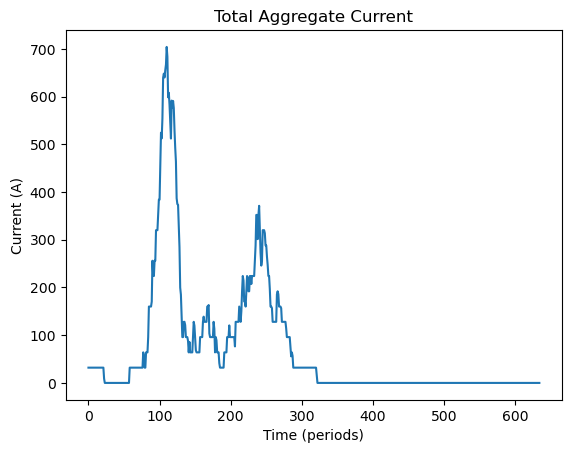

In [13]:
# Plotting aggregate current
agg_current = acnsim.aggregate_current(sim)
plt.plot(agg_current)
plt.xlabel('Time (periods)')
plt.ylabel('Current (A)')
plt.title('Total Aggregate Current')
plt.show()